# Import Librairies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
import ssl

2022-12-22 15:20:18.046456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Labels and Images

In [2]:
def load_labels():
    txt_file_path = "./data/labels.txt"
    labels = []
    with open(txt_file_path, 'r') as f:
        for line in f:
            labels.append(line.strip())
    return labels

In [3]:
game_states = load_labels()
game_states = sorted(game_states)
game_states

['000000001111',
 '000000011110',
 '000000101101',
 '000000111100',
 '000001001011',
 '000001011010',
 '000001101001',
 '000001111000',
 '000010000111',
 '000010010110',
 '000010100101',
 '000010110100',
 '000011000011',
 '000011010010',
 '000011100001',
 '000011110000',
 '000100001110',
 '000100101100',
 '000101001010',
 '000101101000',
 '000110000110',
 '000110100100',
 '000111000100',
 '000111100000',
 '001000001101',
 '001000011100',
 '001001001001',
 '001001011000',
 '001010000101',
 '001010010100',
 '001011000001',
 '001011010000',
 '001100001100',
 '001101001000',
 '001110000100',
 '001111000000',
 '010000001011',
 '010000011010',
 '010000101001',
 '010000111000',
 '010010000011',
 '010010010010',
 '010010100001',
 '010010110000',
 '010100001010',
 '010100101000',
 '010110000010',
 '010110100000',
 '011000001001',
 '011000011000',
 '011010000001',
 '011010010000',
 '011100001000',
 '011110000000',
 '100000000111',
 '100000010110',
 '100000100101',
 '100000110100',
 '100001000011

In [4]:
image_height = 224
image_width = 224
batch_size = 32

def load_data():
    # Load Train Data
    train_images = tf.keras.utils.image_dataset_from_directory("./data/BBTrD/", batch_size=batch_size, image_size=(image_height, image_width), shuffle=False)

    # Load Test Data
    test_images =tf.keras.utils.image_dataset_from_directory("./data/BBTeD/", batch_size=batch_size, image_size=(image_height, image_width), shuffle=False)
    return train_images, test_images

In [5]:
train_images, test_images = load_data()

Found 12 files belonging to 81 classes.
Found 34 files belonging to 34 classes.


2022-12-22 15:20:27.142787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# View Class Names of loaded data 

In [6]:
class_names = train_images.class_names
class_names

['000000001111',
 '000000011110',
 '000000101101',
 '000000111100',
 '000001001011',
 '000001011010',
 '000001101001',
 '000001111000',
 '000010000111',
 '000010010110',
 '000010100101',
 '000010110100',
 '000011000011',
 '000011010010',
 '000011100001',
 '000011110000',
 '000100001110',
 '000100101100',
 '000101001010',
 '000101101000',
 '000110000110',
 '000110100100',
 '000111000100',
 '000111100000',
 '001000001101',
 '001000011100',
 '001001001001',
 '001001011000',
 '001010000101',
 '001010010100',
 '001011000001',
 '001011010000',
 '001100001100',
 '001101001000',
 '001110000100',
 '001111000000',
 '010000001011',
 '010000011010',
 '010000101001',
 '010000111000',
 '010010000011',
 '010010010010',
 '010010100001',
 '010010110000',
 '010100001010',
 '010100101000',
 '010110000010',
 '010110100000',
 '011000001001',
 '011000011000',
 '011010000001',
 '011010010000',
 '011100001000',
 '011110000000',
 '100000000111',
 '100000010110',
 '100000100101',
 '100000110100',
 '100001000011

# Visualize the Loaded Data

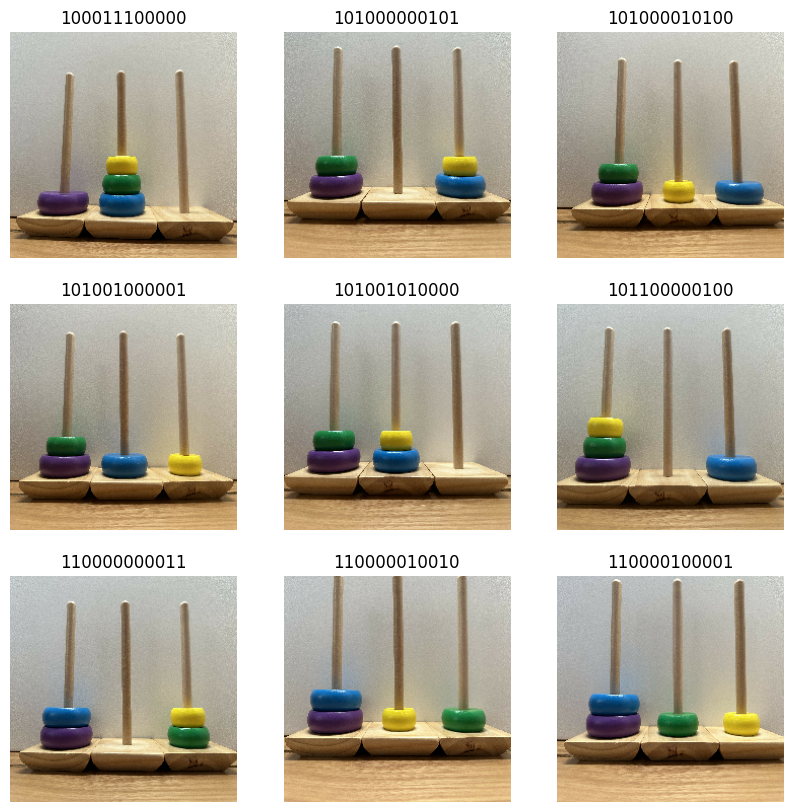

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(game_states[labels[i]])
        plt.axis("off")

# Data Processing

## Resize & Rescale Images

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

train_images = train_images.map(lambda x, y: (resize_and_rescale(x), y))
test_images = train_images.map(lambda x, y: (resize_and_rescale(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Data Augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomBrightness(0.2)
])
augmented_data = train_images.map(lambda x, y: (data_augmentation(x), y))
train_images = train_images.concatenate(augmented_data)
train_images = train_images.map(lambda x, y: (resize_and_rescale(x), y))

# Import RESNET-50

In [10]:
ssl._create_default_https_context = ssl._create_unverified_context
resnet_model = ResNet50(weights='imagenet', include_top=False)

# Define new CNN Model using RESNET-50

In [11]:
cnn_model_resnet_no_freeze = tf.keras.Sequential([
    layers.Rescaling(1./255),
    resnet_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    layers.Dense(81, activation='softmax')
])

# Define a CNN-Model Optimizer

In [12]:
cnn_model_resnet_no_freeze.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Train CNN Model with 10 epochs

In [13]:
cnn_model_resnet_no_freeze.fit(train_images,epochs=10)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2/2 [==============================] - 37s 6s/step - loss: 5.0809 - accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 12s 5s/step - loss: 3.2484 - accuracy: 0.4583
Epoch 3/10
2/2 [==============================] - 10s 4s/step - loss: 2.8206 - accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 10s 4s/step - loss: 2.6660 - accuracy: 0.5417
Epoch 5/10
2/2 [==============================] - 10s 5s/step - loss: 2.3976 - accuracy: 0.5417
Epoch 6/10
2/2 [==============================] - 13s 5s/step - loss: 2.7762 - accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 11s 5s/step - loss: 2.3856 - accuracy: 0.5000
Epoch 8/10
2/2 [==============================] - 10s 4s/step - loss: 2.7379 - accuracy: 0.5417
Epoch 9/10
2/2 [==============================] - 9s 4s/step - loss: 2.4468 - accuracy: 0.5000
Epoch 10/10
2/2 [==============================] - 12s 5s/step - loss: 2.3148 - accuracy: 0.5417


# Predict states

In [14]:
prediction = cnn_model_resnet_no_freeze.predict(test_images)

1/1 [==============================] - 4s 4s/step


# Freeze some RESNET Layers

In [15]:
resnet_model_freeze = ResNet50(weights='imagenet', include_top=False)
for layer in resnet_model_freeze.layers[:143]:
    layer.trainable = False

# Define new CNN Model

In [16]:
cnn_model_resnet_freeze = tf.keras.Sequential([
    layers.Rescaling(1./255),
    resnet_model_freeze,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    layers.Dense(81, activation='softmax')
])

# Add Optimizer

In [17]:
cnn_model_resnet_freeze.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Train CNN Model with 10 epochs

In [19]:
cnn_model_resnet_freeze.fit(train_images,epochs=10)

Epoch 1/10
2/2 [==============================] - 7s 3s/step - loss: 2.8429 - accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 6s 3s/step - loss: 2.7388 - accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 5s 3s/step - loss: 2.5991 - accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 5s 3s/step - loss: 2.6308 - accuracy: 0.5833
Epoch 5/10
2/2 [==============================] - 5s 3s/step - loss: 2.5253 - accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 5s 3s/step - loss: 2.2228 - accuracy: 0.5417
Epoch 7/10
2/2 [==============================] - 5s 3s/step - loss: 2.4487 - accuracy: 0.5417
Epoch 8/10
2/2 [==============================] - 5s 3s/step - loss: 2.1744 - accuracy: 0.6250
Epoch 9/10
2/2 [==============================] - 5s 3s/step - loss: 2.1201 - accuracy: 0.5833
Epoch 10/10
2/2 [==============================] - 5s 3s/step - loss: 2.5356 - accuracy: 0.5833
